In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

import joblib
import os
from tqdm import tqdm

In [6]:
sig_df = pd.read_parquet("/home/dajiang/2hdm/DNN/processed_files/low_mass/low_mass_sig_df.parquet", engine="fastparquet")
ttbar_df = pd.read_parquet("/home/dajiang/2hdm/DNN/processed_files/ttbar/ttbar_df.parquet", engine="fastparquet").sample(n=len(sig_df))

In [7]:
sig_df

,nBjets_NOSYS,nLjets_NOSYS,bjet1_pt_NOSYS,bjet1_phi_NOSYS,bjet1_eta_NOSYS,bjet1_mass_NOSYS,bjet2_pt_NOSYS,bjet2_phi_NOSYS,bjet2_eta_NOSYS,bjet2_mass_NOSYS,...,deltaR_Hp_ljet3,deltaR_Hp_ljet4,deltaR_Hp_lepton,deltaR_WfromH_bjet1,deltaR_WfromH_bjet2,deltaR_WfromH_ljet1,deltaR_WfromH_ljet2,deltaR_WfromH_ljet3,deltaR_WfromH_ljet4,deltaR_WfromH_lepton
0,2,3,85.285301,-0.136517,0.308267,13.729636,55.718781,-3.076673,-0.462943,8.637157,...,4.541549,NaN,0.084567,3.452599,3.376643,1.033386,3.707006,3.075548,NaN,4.116314
1,2,4,89.784004,2.122825,-0.822019,8.702620,60.557709,-2.926201,-2.005772,7.648359,...,6.041951,2.126878,0.935224,0.594194,1.134970,3.146389,0.298251,5.868302,1.932041,0.922186
2,2,2,103.114975,0.555897,-0.599903,18.121708,89.542030,-2.856173,0.920247,16.511604,...,NaN,NaN,2.141778,3.786648,1.659035,2.111785,1.038801,NaN,NaN,3.203845
3,3,3,174.580948,2.801662,-1.255634,10.797685,62.477776,-2.178914,-0.090223,8.301620,...,0.738109,NaN,0.584595,0.718235,2.112780,4.208847,1.491534,0.310687,NaN,0.888132
4,2,4,132.609756,-2.703979,2.099365,13.390602,60.771976,0.432030,2.244661,7.473642,...,1.641683,3.496776,0.918277,1.916123,1.231344,3.430892,1.020991,1.062418,2.008312,3.136477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39866,3,4,113.347717,2.115343,0.246165,14.146431,35.699600,-1.387733,0.027306,4.185276,...,2.820989,0.793433,1.390389,1.367509,2.160375,4.196057,0.595649,1.670415,2.014637,0.597605
39867,2,3,46.711956,0.695274,-0.993221,5.475868,28.741463,1.192056,-2.165656,4.177058,...,3.016091,NaN,1.076348,2.369910,2.867400,0.453536,1.997147,1.031113,NaN,1.651135
39868,2,6,259.753632,1.845157,-0.650813,21.176867,39.101398,0.415177,0.426196,6.896639,...,0.758546,2.931900,3.128548,3.109083,1.324110,2.734617,1.879131,3.490487,0.787479,0.287400
39869,2,3,110.385735,-2.587608,0.268966,21.328876,59.845810,0.624147,-0.262109,9.751234,...,1.493564,NaN,1.683934,1.965509,1.177923,2.560036,2.283780,0.982196,NaN,0.086590


In [8]:
# Combine signal and ttbar, then shuffle
df = pd.concat([ttbar_df, sig_df]).sample(frac=1).reset_index(drop=True)
# Truth Labels
y_df= df.pop("Class")

In [9]:
# Check access to GPU
torch.cuda.is_available()

# Assign the name to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# List of all our features (134 total)
non_features = [
    "nBjets_NOSYS",
    "nLjets_NOSYS",
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS",
    "weight_beamspot",
    "weight_mc_NOSYS",
    "weight_btagSF_DL1dv01_Continuous_NOSYS",
    "weight_pileup_NOSYS",
    "weight_jvt_effSF_NOSYS",
    "ljet3_pt_NOSYS",
    "ljet3_phi_NOSYS",
    "ljet3_eta_NOSYS",
    "ljet3_mass_NOSYS",
    "ljet4_pt_NOSYS",
    "ljet4_phi_NOSYS",
    "ljet4_eta_NOSYS",
    "ljet4_mass_NOSYS"]

required_features = [
    "bjet1_pt_NOSYS",
    "bjet1_phi_NOSYS",
    "bjet1_eta_NOSYS",
    "bjet1_mass_NOSYS",
    "bjet2_pt_NOSYS",
    "bjet2_phi_NOSYS",
    "bjet2_eta_NOSYS",
    "bjet2_mass_NOSYS",
    "A_pt_fitted_NOSYS",
    "A_phi_fitted_NOSYS",
    "A_eta_fitted_NOSYS",
    "A_mass_fitted_NOSYS",
    "Hp_pt_fitted_NOSYS",
    "Hp_phi_fitted_NOSYS",
    "Hp_eta_fitted_NOSYS",
    "Hp_mass_fitted_NOSYS"]

extra_features = [col for col in list(df) if col not in non_features and col not in required_features]

In [15]:
# Create a Model Class that inherits nn.Module
class Model(nn.Module):
    
    # Build the model architecture
    def __init__(self, in_features=30, h1=30, h2=30, out_features=1, dropout_rate=0.4):
        super().__init__() # Instantiate our nn.Module
        self.fc1 = nn.Linear(in_features, h1) 
        self.norm1 = nn.LayerNorm(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.norm2 = nn.LayerNorm(h2)
        self.out = nn.Linear(h2,out_features)
        self.dropout = nn.Dropout(dropout_rate)
    
    # Build forward function
    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.out(x)
        return torch.sigmoid(x)

In [16]:
def process_features(num_extra):
    """
    Adds a number of extra features (num_extra), sampled from the extra_features list, to the required_features list. 
    Creates a DataFrame using these features, then scales them to unit Gaussian, where -999 values are set to the mean.
    Returns:
    X: torch Tensor for the standardized feature information
    y: torch Tensor for the truth labels (0 and 1)
    features: list of all features used
    sampled_features: list of the names of the sampled features
    """
    # Features to use
    sampled_features = random.sample(extra_features,num_extra)
    features = required_features + sampled_features  

    # Scale the features to unit Gaussian
    df_features = df[features].copy()
    df_features.replace(-999, np.nan, inplace=True)
    pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean',add_indicator=False)),
    ('scaler', StandardScaler())
    ])
    X_scaled = pipeline.fit_transform(df_features)

    # Convert the features to torch tensors for training, then send to GPU
    X = torch.tensor(X_scaled)
    y = torch.tensor([y_df]).reshape(-1,1)
    X = X.to(device)
    y = y.to(device)
    
    return X, y, features, sampled_features

In [17]:
def binary_accuracy(preds, y, threshold=0.5):
    # Round predictions based on threshold
    rounded_preds = []

    # Loop over all predictions
    for i in range(len(preds)):
        if preds[i] >= threshold: # classify as signal
            rounded_preds.append(1)
        if preds[i] < threshold: # classify as ttbar
            rounded_preds.append(0)

    # Make the comparison objects the same format (np.array)
    rounded_preds = np.array(rounded_preds)
    y = np.array(y.reshape(-1))
    
    # Convert rounded predictions and true labels to integers (0 or 1)
    correct = (rounded_preds == y) 
    
    # Calculate accuracy
    accuracy = correct.sum() / len(correct)
    
    return accuracy

In [18]:
def train_model(X,y,num_epochs):
    """
    Trains the model for num_epochs amount of epochs.
    Returns:
    
    """
    # Initialize the model
    model = Model()
    model.to(device)
    # Split training and validation sets
    seed = 0
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=seed)
    # Loss and Hyperparameters
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    
    # Training 
    epochs = num_epochs
    for epoch in range(epochs):
        model.train()
        # Training phase
        # Forward pass and compute training loss
        y_pred_train = model.forward(X_train.float())
        train_loss = criterion(y_pred_train.float(), y_train.float())
        
        # Back propagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Validation phase
        if epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                y_pred_test = model.forward(X_test.float())
                # Compute Validation Loss
                val_loss = criterion(y_pred_test.float(), y_test.float())
                # Compute AUC
                fpr, tpr, thresholds = roc_curve(y_test.cpu(), y_pred_test.cpu())
                roc_auc = auc(fpr, tpr)
                # Compute Accuracy and Threshold
                accuracy = binary_accuracy(y_pred_test.cpu(), y_test.cpu())
                

    return (train_loss.item(), val_loss.item()), roc_auc, accuracy

In [ ]:
# Train many times, find the best performance
iterations = 5000
losses = []
auc_scores = []
accuracies = []
sampled_features_list = []
for i in tqdm(range(iterations), desc="Training {} iterations".format(iterations)):
    X, y, features, sampled = process_features(14)
    loss, auc_score, accuracy = train_model(X,y,1000)
    losses.append(loss)
    auc_scores.append(auc_score)
    accuracies.append(accuracy)
    sampled_features_list.append(sampled)    

Training 5000 iterations:  35%|███▌      | 1763/5000 [2:21:48<4:22:02,  4.86s/it]

In [ ]:
losses = np.array(losses)
auc_scores = np.array(auc_scores)
accuracies = np.array(accuracies)

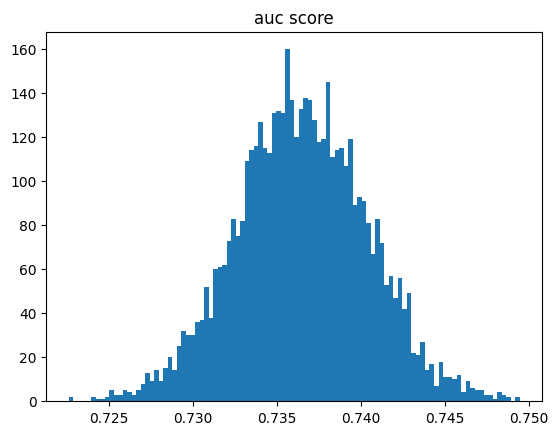

In [67]:
fig, ax = plt.subplots()
ax.hist(auc_scores,bins=100)
ax.set_title("auc score")
fig.show()

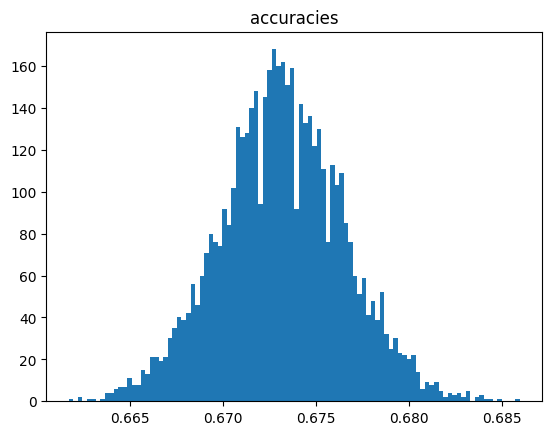

In [68]:
fig, ax = plt.subplots()
ax.hist(accuracies,bins=100)
ax.set_title("accuracies")
fig.show()

In [201]:
from collections import Counter

# Sort the AUCs from least to greatest
sorted_aucs = sorted(auc_scores)

# Find the corresponding index for the AUCs
indices = []
for i in range(len(sorted_aucs)):
    index = int(np.where(auc_scores == sorted_aucs[i])[0][0])
    indices.append(index)
indices = np.array(indices)

# Find the features that correspond to the index
extra_features_temp = []
for index in indices:
    extra_features_temp.append(sampled_features_list[index])
extra_features = [item for sublist in extra_features_temp for item in sublist]

# Dictionary: key = feature, value = number of occurences
count_dict = Counter(extra_features)
extra_features_names = count_dict.keys()
extra_features_counts = count_dict.values()

Number of unique extra features used: 110/110
Smallest number of times an extra feature was used: 590
Largest number of times an extra feature was used: 693


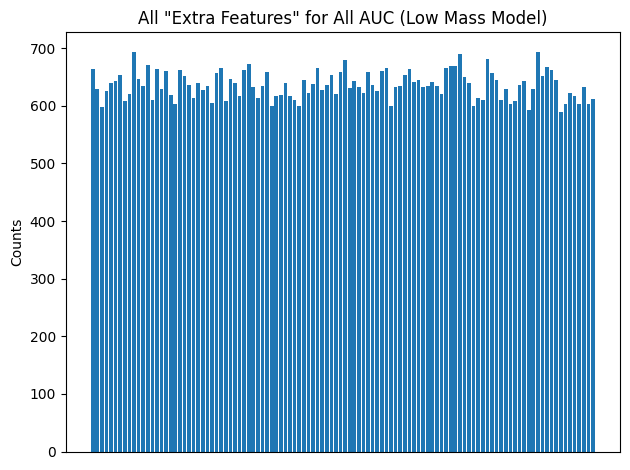

In [231]:
# Summary of feature scan
print("Number of unique extra features used: {}/110".format(len(extra_features_names)))
print("Smallest number of times an extra feature was used: {}".format(min(extra_features_counts)))
print("Largest number of times an extra feature was used: {}".format(max(extra_features_counts)))

fig, ax = plt.subplots()
ax.bar(extra_features_names, extra_features_counts)
ax.set_title('All "Extra Features" for All AUC (Low Mass Model)')
ax.set_ylabel("Counts")
ax.get_xaxis().set_visible(False) # too cluttered of the feature names
plt.tight_layout()
fig.savefig("dnn_optimization_plots/allAUC_extrafeatures_lowmass.png",dpi=300)

In [232]:
# Find the top 30 AUCs
top30_aucs = sorted_aucs[-30:]

# Find the corresponding index for the top 30 AUCs
top30_indices = []
for i in range(len(top30_aucs)):
    top30_index = int(np.where(auc_scores == top_30_aucs[i])[0][0])
    top30_indices.append(top30_index)
top30_indices = np.array(top30_indices)

# Find the features that correspond to the index
top30_extra_features_temp = []
for index in top30_indices:
    top30_extra_features_temp.append(sampled_features_list[index])
top30_extra_features = [item for sublist in top30_extra_features_temp for item in sublist]

# Dictionary: key = feature, value = number of occurences
top30_count_dict = Counter(top30_extra_features)
top30_extra_features_names = top30_count_dict.keys()
top30_extra_features_counts = top30_count_dict.values()

Number of unique extra features used: 103/110
Smallest number of times an extra feature was used: 1
Largest number of times an extra feature was used: 26


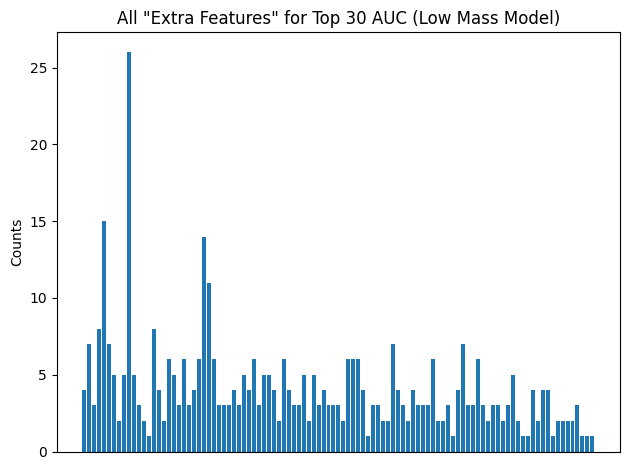

In [233]:
# Summary of feature scan for top 30 AUC
print("Number of unique extra features used: {}/110".format(len(top30_extra_features_names)))
print("Smallest number of times an extra feature was used: {}".format(min(top30_extra_features_counts)))
print("Largest number of times an extra feature was used: {}".format(max(top30_extra_features_counts)))

fig, ax = plt.subplots()
ax.bar(top30_extra_features_names, top30_extra_features_counts)
ax.set_title('All "Extra Features" for Top 30 AUC (Low Mass Model)')
ax.set_ylabel("Counts")
ax.get_xaxis().set_visible(False) # too cluttered of the feature names
plt.tight_layout()
fig.savefig("dnn_optimization_plots/top30AUC_extrafeatures_lowmass.png",dpi=300)

In [234]:
# Get the top 30 most common features from the top 30 AUCs
top_30 = top30_count_dict.most_common(30)

# Separate the strings and their counts
top30_features, top30_counts = zip(*top_30)

Number of unique extra features used: 30/110
Smallest number of times an extra feature was used: 5
Largest number of times an extra feature was used: 26


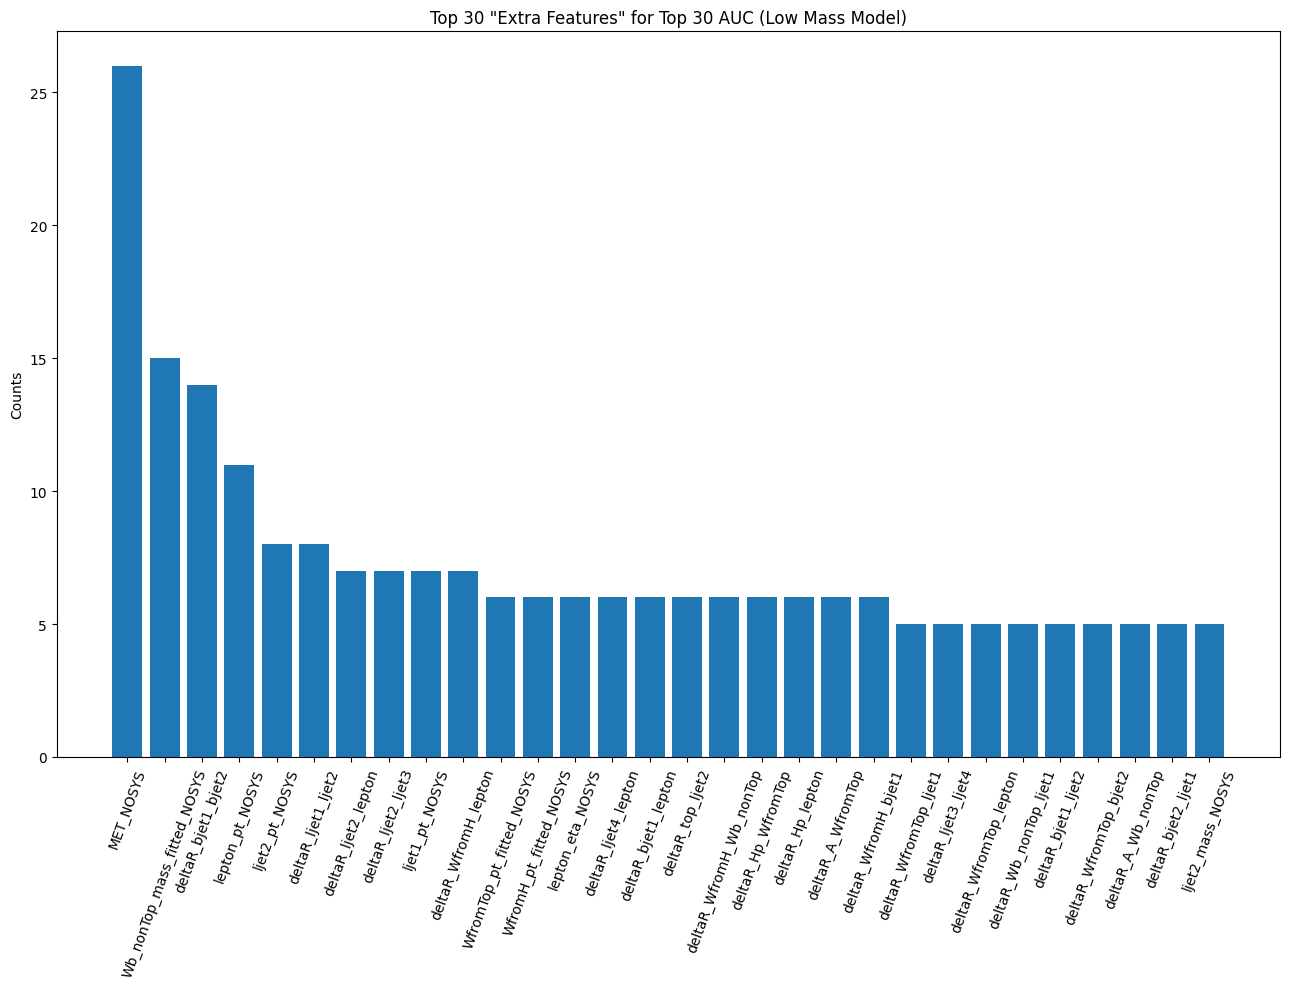

In [235]:
# Summary of feature scan for top 30 most common extra features appearing in top 30 AUC
print("Number of unique extra features used: {}/110".format(len(top30_features)))
print("Smallest number of times an extra feature was used: {}".format(min(top30_counts)))
print("Largest number of times an extra feature was used: {}".format(max(top30_counts)))

fig, ax = plt.subplots(figsize=(13,10))
ax.bar(top30_features, top30_counts)
ax.set_title('Top 30 "Extra Features" for Top 30 AUC (Low Mass Model)')
ax.set_ylabel("Counts")
plt.xticks(rotation=70)
plt.tight_layout()
fig.savefig("dnn_optimization_plots/top30AUC_top30extrafeatures_lowmass.png",dpi=300)

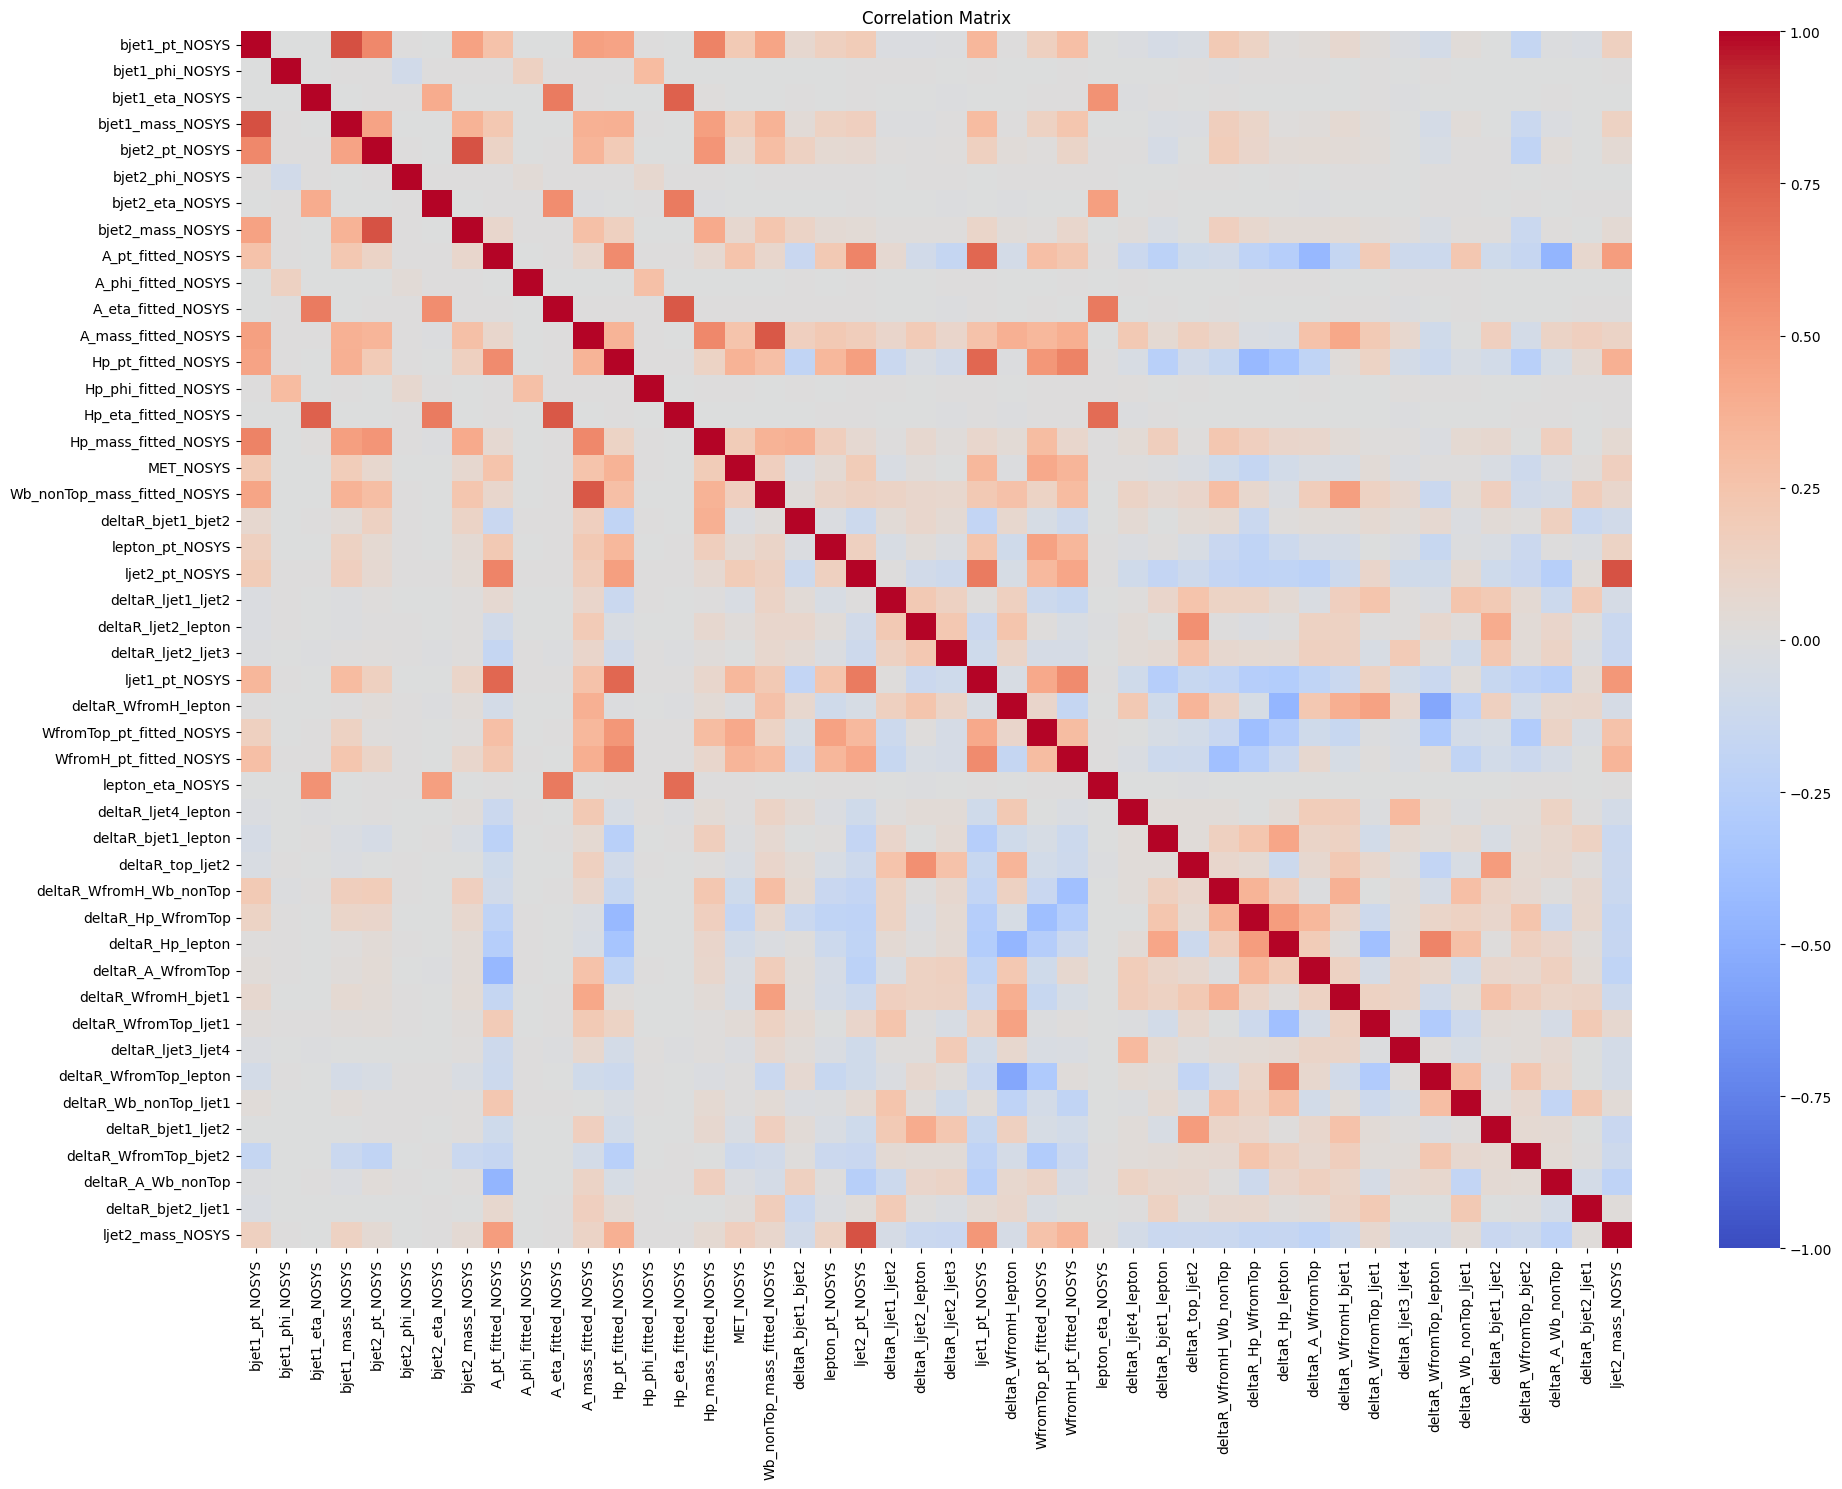

In [149]:
# Correlation plot
top30auc_top30features = ["MET_NOSYS","Wb_nonTop_mass_fitted_NOSYS","deltaR_bjet1_bjet2","lepton_pt_NOSYS",
    "ljet2_pt_NOSYS","deltaR_ljet1_ljet2", "deltaR_ljet2_lepton", "deltaR_ljet2_ljet3", "ljet1_pt_NOSYS",
      "deltaR_WfromH_lepton","WfromTop_pt_fitted_NOSYS","WfromH_pt_fitted_NOSYS","lepton_eta_NOSYS","deltaR_ljet4_lepton",
      "deltaR_bjet1_lepton","deltaR_top_ljet2","deltaR_WfromH_Wb_nonTop", "deltaR_Hp_WfromTop","deltaR_Hp_lepton",
      "deltaR_A_WfromTop", "deltaR_WfromH_bjet1","deltaR_WfromTop_ljet1","deltaR_ljet3_ljet4",
      "deltaR_WfromTop_lepton","deltaR_Wb_nonTop_ljet1","deltaR_bjet1_ljet2","deltaR_WfromTop_bjet2",
      "deltaR_A_Wb_nonTop","deltaR_bjet2_ljet1","ljet2_mass_NOSYS"]

total_features =  required_features + top30auc_top30features
df_total_features = df[total_features].copy()
df_corr = df_total_features.corr()

import seaborn as sns
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title('Correlation Matrix')
plt.tight_layout()
fig.savefig("dnn_optimization_plots/correlation_matrix.png",dpi=300)
fig.show()

In [150]:
df_corr

,bjet1_pt_NOSYS,bjet1_phi_NOSYS,bjet1_eta_NOSYS,bjet1_mass_NOSYS,bjet2_pt_NOSYS,bjet2_phi_NOSYS,bjet2_eta_NOSYS,bjet2_mass_NOSYS,A_pt_fitted_NOSYS,A_phi_fitted_NOSYS,...,deltaR_WfromH_bjet1,deltaR_WfromTop_ljet1,deltaR_ljet3_ljet4,deltaR_WfromTop_lepton,deltaR_Wb_nonTop_ljet1,deltaR_bjet1_ljet2,deltaR_WfromTop_bjet2,deltaR_A_Wb_nonTop,deltaR_bjet2_ljet1,ljet2_mass_NOSYS
bjet1_pt_NOSYS,1.000000,-0.001516,-0.001780,0.806049,0.582512,0.002420,-0.004734,0.460481,0.258211,-0.002379,...,0.074250,0.018196,-0.019149,-0.073392,0.028473,-0.000949,-0.170284,-0.014275,-0.027664,0.150725
bjet1_phi_NOSYS,-0.001516,1.000000,-0.001992,0.004067,0.001534,-0.092530,0.002744,0.002306,0.003784,0.141035,...,-0.002027,0.000756,-0.000584,0.003097,-0.001952,-0.000653,-0.001656,-0.005068,-0.002120,0.004442
bjet1_eta_NOSYS,-0.001780,-0.001992,1.000000,-0.005474,0.000802,0.002310,0.405920,-0.000561,-0.000636,-0.005217,...,-0.001366,0.000031,-0.013876,-0.001833,-0.006412,-0.000248,-0.000941,0.004149,-0.002056,-0.001450
bjet1_mass_NOSYS,0.806049,0.004067,-0.005474,1.000000,0.450740,-0.000766,-0.005157,0.363907,0.225443,-0.001000,...,0.059591,0.017403,-0.002739,-0.063105,0.026314,-0.000779,-0.140063,-0.023199,-0.005990,0.135325
bjet2_pt_NOSYS,0.582512,0.001534,0.000802,0.450740,1.000000,0.002417,-0.003447,0.799198,0.122615,-0.000595,...,0.037567,0.025379,-0.000573,-0.043683,0.004322,0.004490,-0.188644,0.024503,-0.002552,0.050090
bjet2_phi_NOSYS,0.002420,-0.092530,0.002310,-0.000766,0.002417,1.000000,0.001175,0.004330,0.000563,0.032613,...,0.002285,0.000093,-0.002862,0.001086,0.002013,0.006303,-0.003139,0.002559,-0.000400,-0.002311
bjet2_eta_NOSYS,-0.004734,0.002744,0.405920,-0.005157,-0.003447,0.001175,1.000000,-0.002761,0.001553,0.001011,...,-0.001634,-0.000851,-0.006501,0.002235,0.002697,-0.004257,0.004050,-0.000277,0.002604,0.002184
bjet2_mass_NOSYS,0.460481,0.002306,-0.000561,0.363907,0.799198,0.004330,-0.002761,1.000000,0.090707,0.000120,...,0.039156,0.022144,0.010815,-0.031512,0.008318,0.009644,-0.137571,0.015375,-0.006021,0.047169
A_pt_fitted_NOSYS,0.258211,0.003784,-0.000636,0.225443,0.122615,0.000563,0.001553,0.090707,1.000000,-0.000684,...,-0.171439,0.196409,-0.112965,-0.117422,0.228273,-0.106635,-0.163938,-0.461604,0.085234,0.482654
A_phi_fitted_NOSYS,-0.002379,0.141035,-0.005217,-0.001000,-0.000595,0.032613,0.001011,0.000120,-0.000684,1.000000,...,-0.001555,-0.000490,0.000512,0.004802,0.002345,-0.000675,-0.001291,-0.000278,-0.000662,-0.000979


In [151]:
df_corr_abs = df_corr.abs()
df_corr_abs

,bjet1_pt_NOSYS,bjet1_phi_NOSYS,bjet1_eta_NOSYS,bjet1_mass_NOSYS,bjet2_pt_NOSYS,bjet2_phi_NOSYS,bjet2_eta_NOSYS,bjet2_mass_NOSYS,A_pt_fitted_NOSYS,A_phi_fitted_NOSYS,...,deltaR_WfromH_bjet1,deltaR_WfromTop_ljet1,deltaR_ljet3_ljet4,deltaR_WfromTop_lepton,deltaR_Wb_nonTop_ljet1,deltaR_bjet1_ljet2,deltaR_WfromTop_bjet2,deltaR_A_Wb_nonTop,deltaR_bjet2_ljet1,ljet2_mass_NOSYS
bjet1_pt_NOSYS,1.000000,0.001516,0.001780,0.806049,0.582512,0.002420,0.004734,0.460481,0.258211,0.002379,...,0.074250,0.018196,0.019149,0.073392,0.028473,0.000949,0.170284,0.014275,0.027664,0.150725
bjet1_phi_NOSYS,0.001516,1.000000,0.001992,0.004067,0.001534,0.092530,0.002744,0.002306,0.003784,0.141035,...,0.002027,0.000756,0.000584,0.003097,0.001952,0.000653,0.001656,0.005068,0.002120,0.004442
bjet1_eta_NOSYS,0.001780,0.001992,1.000000,0.005474,0.000802,0.002310,0.405920,0.000561,0.000636,0.005217,...,0.001366,0.000031,0.013876,0.001833,0.006412,0.000248,0.000941,0.004149,0.002056,0.001450
bjet1_mass_NOSYS,0.806049,0.004067,0.005474,1.000000,0.450740,0.000766,0.005157,0.363907,0.225443,0.001000,...,0.059591,0.017403,0.002739,0.063105,0.026314,0.000779,0.140063,0.023199,0.005990,0.135325
bjet2_pt_NOSYS,0.582512,0.001534,0.000802,0.450740,1.000000,0.002417,0.003447,0.799198,0.122615,0.000595,...,0.037567,0.025379,0.000573,0.043683,0.004322,0.004490,0.188644,0.024503,0.002552,0.050090
bjet2_phi_NOSYS,0.002420,0.092530,0.002310,0.000766,0.002417,1.000000,0.001175,0.004330,0.000563,0.032613,...,0.002285,0.000093,0.002862,0.001086,0.002013,0.006303,0.003139,0.002559,0.000400,0.002311
bjet2_eta_NOSYS,0.004734,0.002744,0.405920,0.005157,0.003447,0.001175,1.000000,0.002761,0.001553,0.001011,...,0.001634,0.000851,0.006501,0.002235,0.002697,0.004257,0.004050,0.000277,0.002604,0.002184
bjet2_mass_NOSYS,0.460481,0.002306,0.000561,0.363907,0.799198,0.004330,0.002761,1.000000,0.090707,0.000120,...,0.039156,0.022144,0.010815,0.031512,0.008318,0.009644,0.137571,0.015375,0.006021,0.047169
A_pt_fitted_NOSYS,0.258211,0.003784,0.000636,0.225443,0.122615,0.000563,0.001553,0.090707,1.000000,0.000684,...,0.171439,0.196409,0.112965,0.117422,0.228273,0.106635,0.163938,0.461604,0.085234,0.482654
A_phi_fitted_NOSYS,0.002379,0.141035,0.005217,0.001000,0.000595,0.032613,0.001011,0.000120,0.000684,1.000000,...,0.001555,0.000490,0.000512,0.004802,0.002345,0.000675,0.001291,0.000278,0.000662,0.000979


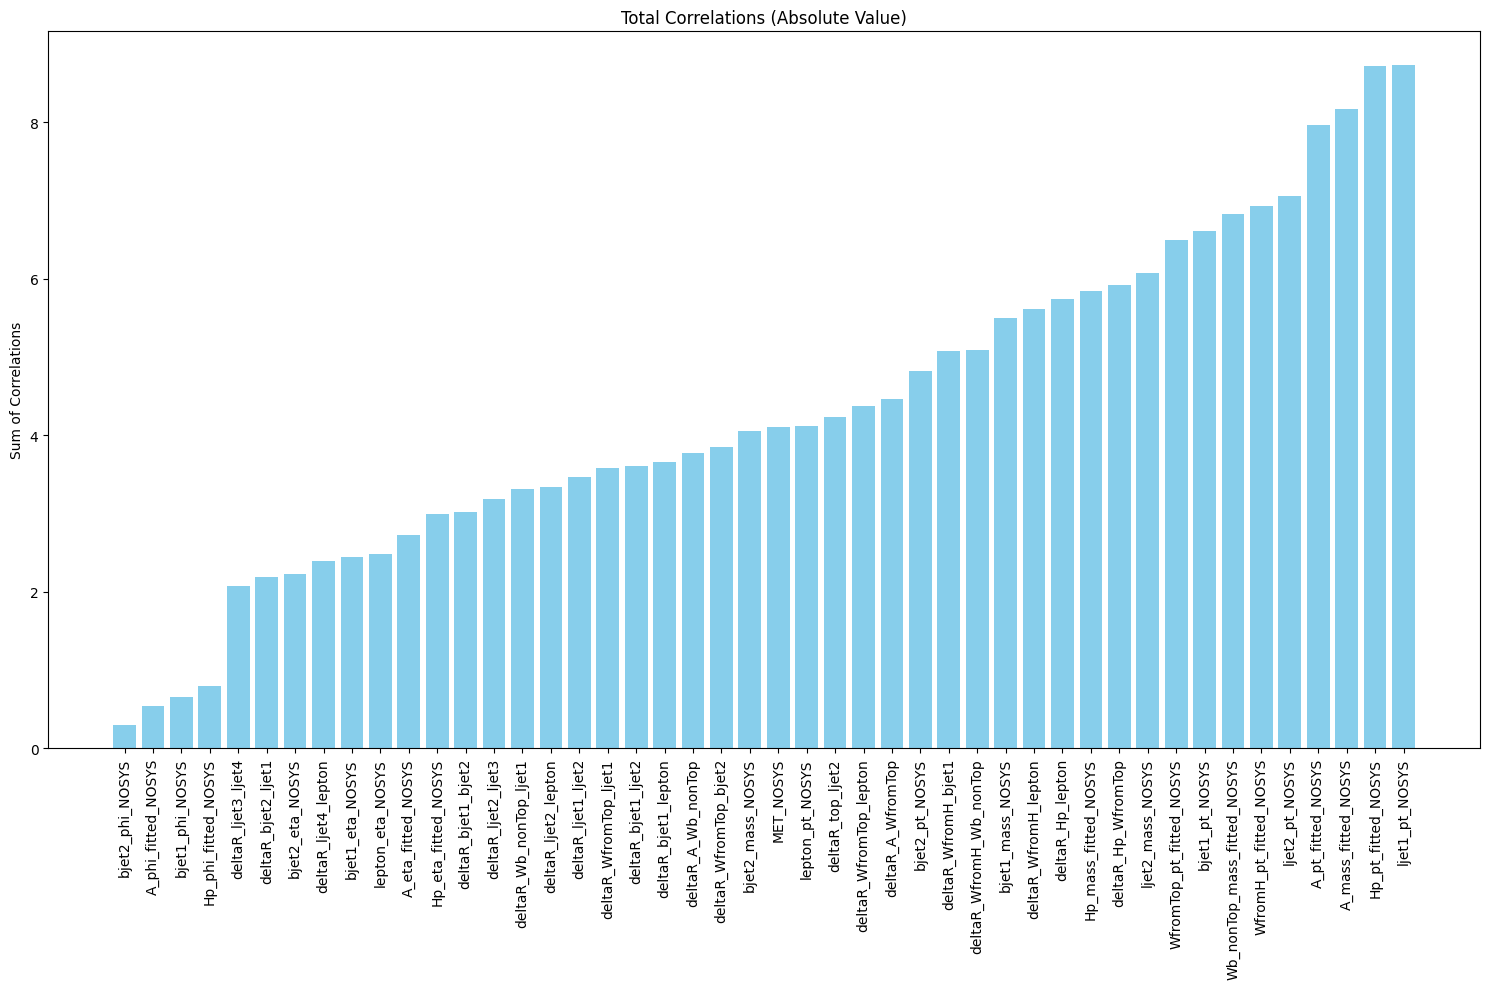

In [152]:
df_row_sums = df_corr_abs.sum(axis=1) - 1
df_row_sums.to_frame()
df_corr_sum = df_row_sums.sort_values()

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(df_corr_sum.index, df_corr_sum, color='skyblue')
ax.set_title("Total Correlations (Absolute Value)")
ax.set_ylabel("Sum of Correlations")
plt.xticks(rotation=90)
plt.tight_layout()
fig.savefig("dnn_optimization_plots/correlation_sum.png",dpi=300)
fig.show()

In [153]:
feature_counts = np.array([26,15,14,11,8,8,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5])

In [155]:
feature_scores_dict = {}
for i in range(30):
    final_score = feature_counts[i] - df_corr_sum[top30auc_top30features[i]]
    feature_name = top30auc_top30features[i]
    feature_scores_dict[feature_name] = final_score

In [156]:
feature_scores_dict

{'MET_NOSYS': 21.896342952985503,
 'Wb_nonTop_mass_fitted_NOSYS': 8.167397319650968,
 'deltaR_bjet1_bjet2': 10.981063591416099,
 'lepton_pt_NOSYS': 6.875026518550587,
 'ljet2_pt_NOSYS': 0.9386241573426215,
 'deltaR_ljet1_ljet2': 4.527433687634,
 'deltaR_ljet2_lepton': 3.6543283037543706,
 'deltaR_ljet2_ljet3': 3.8100922895226823,
 'ljet1_pt_NOSYS': -1.7282840987575057,
 'deltaR_WfromH_lepton': 1.382152113033122,
 'WfromTop_pt_fitted_NOSYS': -0.5039945944358024,
 'WfromH_pt_fitted_NOSYS': -0.9277086316565892,
 'lepton_eta_NOSYS': 3.520653054064083,
 'deltaR_ljet4_lepton': 3.6105475429586416,
 'deltaR_bjet1_lepton': 2.337075982244489,
 'deltaR_top_ljet2': 1.7608199244208267,
 'deltaR_WfromH_Wb_nonTop': 0.9041432829332701,
 'deltaR_Hp_WfromTop': 0.07564509613771442,
 'deltaR_Hp_lepton': 0.2560765048077087,
 'deltaR_A_WfromTop': 1.5304313609323392,
 'deltaR_WfromH_bjet1': 0.9170226438595837,
 'deltaR_WfromTop_ljet1': 1.4114552775667777,
 'deltaR_ljet3_ljet4': 2.919356405434191,
 'deltaR_Wf

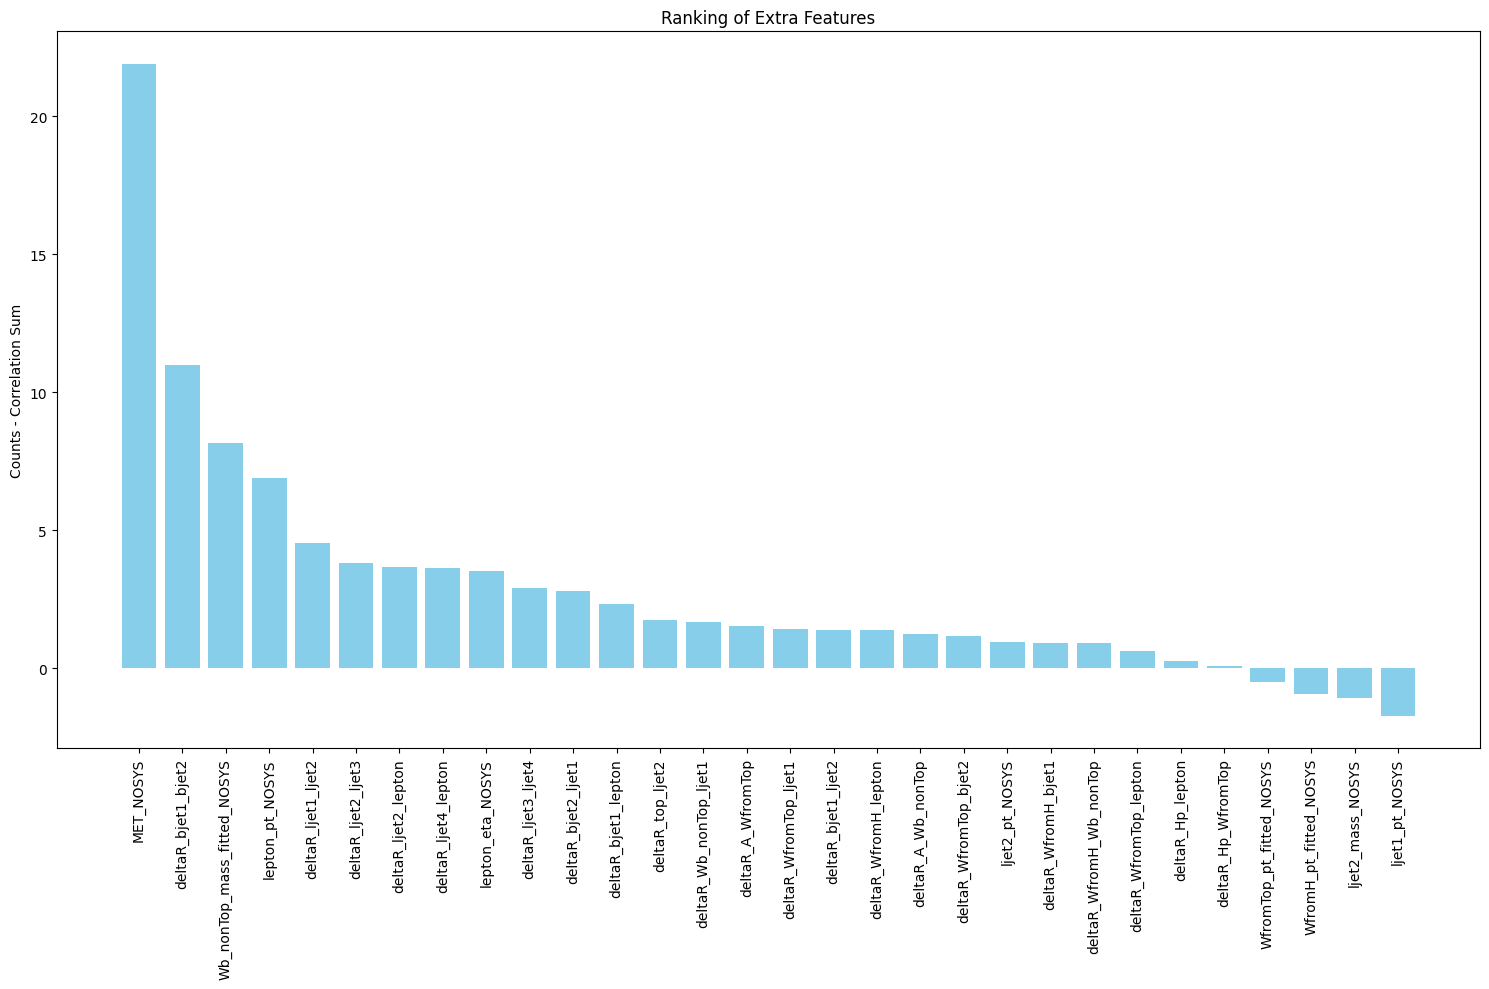

In [175]:
# Separate the strings and their counts
feature_scores_dict_sorted = dict(sorted(feature_scores_dict.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(feature_scores_dict_sorted.keys(), feature_scores_dict_sorted.values(),color='skyblue')
ax.set_title("Ranking of Extra Features")
ax.set_ylabel("Counts - Correlation Sum")
plt.xticks(rotation=90)
plt.tight_layout()
fig.savefig("dnn_optimization_plots/rankingtop30.png",dpi=300)
fig.show()